# CUNY SPS MSDS – DATA 620 Final Project – Recipe Analysis

### Betsy Rosalen and Mikhail Groysman

## Project Overview


### Final Project 

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Final Project Presentation 

We’ll schedule a short presentation for each team, either in our last scheduled meet-up or in additional office hours to be scheduled during the last week of classes.

### Policy on Collaboration 

You may work in a team of up to three people. Each project team member is responsible for understanding and being able to explain all of the submitted project code. Remember that you can take work that you find elsewhere as a base to build on, but you need to acknowledge the source, so that I base your grade on what you contributed, not on what you started with!

## Recipe ingredients data

We chose a dataset that we found on the [Data Is Plural — Structured Archive](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0) that conists of 56,498 recipes from various cuisines that were scraped from 3 popular recipe websites.

__Description from Data Is Plural__

> For their 2011 paper, “Flavor network and the principles of food pairing,” four scientists analyzed 56,498 recipes downloaded from three websites — allrecipes.com, epicurious.com, and menupan.com. To support their findings, the authors published two datasets. One names the cuisine and ingredients for each recipe. The other dataset counts how often any two ingredients appeared in the same recipe. (Parmesan cheese and beef appeared together 93 times; starfruit and Algerian geranium oil just once.) Related: “food2vec – Augmented cooking with machine intelligence,” published last month. [h/t Rob Barry](http://rob-barry.com/).

The __original research article__, Flavor network and the principles of food pairing, can be found here: __[Flavor network and the principles of food pairing](http://www.nature.com/articles/srep00196)__  
The __additional related article__ cited above can be found here: __[food2vec – Augmented cooking with machine intelligence](https://jaan.io/food2vec-augmented-cooking-machine-intelligence)__  

__The data__ is easily downloaded in CSV format from the __[Electronic supplementary material](https://www.nature.com/articles/srep00196#Sec8)__ section of the Flavor network and the principles of food pairing research paper webpage.

__The data downloads consist of the following two files:__

- srep00196-s2.csv - counts of how many flavour compounds any two ingredients share
- srep00196-s3.csv - one record per recipe with the ingredients listed in columns

__Structure of the srep00196-s2 dataset:__

- The paired ingredients are listed one each in the first two columns and the count of the number of times that pair of ingredients are found in the same recipe in all recipes across all cuisines in the dataset is in the third column. We decided not to use this dataset, since we opted instead to create our own counts grouped by cuisine from the other file. Information about the cuisines for each pairing are not available in this file.  

- Additionally, there is some confusion about what this data actually represents since a different source, [Recipes for learning](https://www.visibledata.co.uk/blog/2018/02/18/2018-02-18-recipes-for-learning/), suggested that the third column in fact represents the number of flavor compaunds that the two ingredients share.  As a result we decided not to use this data and to create our own list of common pairs of ingredients from the other file.

__Structure of the srep00196-s3 dataset:__

- The type of cuisine is listed in the first column with the remaining columns containing one ingredient per column. There are 32 additional columns in the file, so the maximum number of ingredients for any one recipe is 32.
    - The cuisine categories include:
        - African
        - EastAsian
        - EasternEuropean
        - LatinAmerican
        - MiddleEastern
        - NorthAmerican
        - NorthernEuropean
        - SouthAsian
        - SoutheastAsian
        - SouthernEuropean
        - WesternEuropean

Significant data manipulation was necessary to reshape and analyze this dataset both as a text and as a network.  

## Loading Libraries

In [196]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.tokenize import word_tokenize

import networkx as nx
from networkx.algorithms import bipartite as bi

from scipy import stats
import math
import random
random.seed(250)

import matplotlib.pyplot as plt
%matplotlib inline

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (15,12)

## Loading Data

In [197]:
file_name ='https://raw.githubusercontent.com/betsyrosalen/DATA_620_Web_Analytics/master/Final_Project_Data/srep00196-s3.csv'

columns = ['Cuisine', 'ingred1','ingred2','ingred3','ingred4','ingred5','ingred6','ingred7','ingred8','ingred9',
           'ingred10','ingred11','ingred12','ingred13','ingred14','ingred15','ingred16','ingred17','ingred18',
           'ingred19','ingred20','ingred21','ingred22','ingred23','ingred24','ingred25','ingred26','ingred27',
           'ingred28','ingred29','ingred30','ingred31','ingred32']

recipes = pd.read_csv(file_name, header=None, skiprows=4, names=columns, encoding = 'utf-8',)

recipes.head()
print("There are "+str(recipes.shape[0])+ " recipes with a maximum of "+str(recipes.shape[1]-1)+" ingredients each.")

Cuisine        ingred1   ingred2    ingred3   ingred4   ingred5   ingred6  \
0  African        chicken  cinnamon  soy_sauce     onion    ginger       NaN   
1  African  cane_molasses    ginger      cumin    garlic  tamarind     bread   
2  African         butter    pepper      onion  cardamom   cayenne    ginger   
3  African      olive_oil    pepper      wheat      beef     onion  cardamom   
4  African          honey     wheat      yeast       NaN       NaN       NaN   

          ingred7  ingred8   ingred9 ingred10 ingred11 ingred12     ingred13  \
0             NaN      NaN       NaN      NaN      NaN      NaN          NaN   
1       coriander  vinegar     onion     beef  cayenne  parsley  wheat_bread   
2  cottage_cheese   garlic  brassica      NaN      NaN      NaN          NaN   
3           cumin   garlic      rice     leek      NaN      NaN          NaN   
4             NaN      NaN       NaN      NaN      NaN      NaN          NaN   

  ingred14       ingred15 ingred16 ingred17 ingred18 ingred19 ingred20  \
0      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
1   yogurt  vegetable_oil      egg      NaN      NaN      NaN      NaN   
2      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN            NaN      NaN      NaN      NaN      NaN      NaN   

  ingred21 ingred22 ingred23 ingred24 ingred25 ingred26 ingred27 ingred28  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  ingred29 ingred30 ingred31 ingred32  
0      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN

There are 56498 recipes with a maximum of 32 ingredients each.


## Create a Corpus from the Data

First we have to figure out how to get all the ingredients into one string that can be wrtten to a file to create each text in our corpus.  After some trial and error we got the following code to do what we needed.

In [21]:
for index, r in recipes.head().iterrows():
    string = ""
    for col in r[1:32]:
        if type(col) == str:
            string = string+str(col)+" "
    print(string)

chicken cinnamon soy_sauce onion ginger 
cane_molasses ginger cumin garlic tamarind bread coriander vinegar onion beef cayenne parsley wheat_bread yogurt vegetable_oil egg 
butter pepper onion cardamom cayenne ginger cottage_cheese garlic brassica 
olive_oil pepper wheat beef onion cardamom cumin garlic rice leek 
honey wheat yeast 


Now we can use a [function we found on StackOverflow](https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk/49104725) and modify it to create our corpus.  I am putting this code in a markdown cell so that it doesn't run again each time we run the notebook. Copy the code into a code cell or change the cell to a code cell to run it to create your text files if you want to reproduce this analysis.

#https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk/49104725

```
def CreateCorpusFromDataFrame(corpusfolder,df):
    for index, r in df.iterrows():
        id = 'recipe'+str(index)
        title = 'recipe'+str(index)
        body = ""
        for col in r[1:32]:
            if type(col) == str:
                body = body+str(col)+" "
        cuisine = r['Cuisine']
        fname = str(cuisine)+'_'+str(id)+'.txt'
        corpusfile = open(corpusfolder+'/'+fname,'a')
        corpusfile.write(str(body)+" "+str(title))
        corpusfile.close()

CreateCorpusFromDataFrame('Final_Project_corpusfolder',recipes)
```

Finally we can run the following code to create our corpus in NLTK.

In [41]:
my_corpus=CategorizedPlaintextCorpusReader('Final_Project_corpusfolder/',r'.*', cat_pattern=r'(.*)_.*')

In [47]:
my_corpus.fileids()[1:15]

['African_recipe1.txt',
 'African_recipe10.txt',
 'African_recipe100.txt',
 'African_recipe101.txt',
 'African_recipe102.txt',
 'African_recipe103.txt',
 'African_recipe104.txt',
 'African_recipe105.txt',
 'African_recipe106.txt',
 'African_recipe107.txt',
 'African_recipe108.txt',
 'African_recipe109.txt',
 'African_recipe11.txt',
 'African_recipe110.txt']

In [43]:
my_corpus.categories()

['African',
 'EastAsian',
 'EasternEuropean',
 'LatinAmerican',
 'MiddleEastern',
 'NorthAmerican',
 'NorthernEuropean',
 'SouthAsian',
 'SoutheastAsian',
 'SouthernEuropean',
 'WesternEuropean']

In [44]:
my_corpus.words(categories='African')

['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger', ...]

In [45]:
my_corpus.sents(categories=['EasternEuropean', 'NorthernEuropean', 'SouthernEuropean', 'WesternEuropean'])

[['butter', 'onion', 'potato', 'haddock', 'black_pepper', 'parsley', 'celery', 'milk_fat', 'smoke', 'milk', 'cream', 'recipe2864'], ['butter', 'lemon_juice', 'wheat', 'yeast', 'apricot', 'milk_fat', 'egg', 'milk', 'recipe2865'], ...]

## Exploratory Data Analysis

In [198]:
#EDA_DF 1. We get column description.
df = recipes.describe()
df.iloc[:, :12]
df.iloc[:, 12:23]
df.iloc[:, 23:]

Cuisine ingred1 ingred2 ingred3 ingred4 ingred5 ingred6 ingred7  \
count           56498   56498   56144   55001   52681   48870   43429   37026   
unique             11     294     319     316     329     319     317     309   
top     NorthAmerican  butter   wheat   wheat   onion   onion     egg  garlic   
freq            41524   17761    7010    8399    5156    2984    2775    2715   

       ingred8 ingred9 ingred10 ingred11  
count    30197   23539    17968    13231  
unique     299     290      287      264  
top     garlic  garlic   garlic      egg  
freq      2727    2060     1428      996

ingred12 ingred13 ingred14       ingred15 ingred16 ingred17 ingred18  \
count      9671     6930     4756           3177     2057     1268      766   
unique      237      229      217            186      149      125      107   
top         egg      egg    cream  vegetable_oil      egg      egg      egg   
freq        748      511      294            257      252      161       98   

       ingred19  ingred20  ingred21 ingred22  
count       491       276       159      100  
unique       93        74        50       42  
top         egg  turmeric  turmeric      egg  
freq         65        23        15        8

ingred23  ingred24     ingred25 ingred26 ingred27 ingred28  ingred29  \
count         70        40           19       13        9        8         6   
unique        37        27           15       11        7        6         6   
top     turmeric  turmeric  bell_pepper    smoke    thyme      egg  turmeric   
freq           8         5            3        2        2        3         1   

        ingred30 ingred31 ingred32  
count          3        2        2  
unique         3        2        2  
top     turmeric    chive      egg  
freq           1        1        1

#### Distribution of number of ingredients

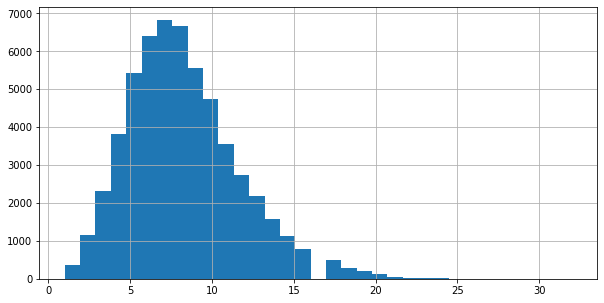

In [199]:
# Add #of_ingred column 
recipes['#of_ingred'] = 32-recipes.isnull().sum(axis=1)
# Plot distribution
recipes['#of_ingred'].hist(bins=33, figsize=(10,5))

Number of ingredients in recipies is right skewed. But generally we have very few recipies with more than 15 ingredients.

In [200]:
# Add recipeID (recipe#) column 
recipes['recipe#'] = recipes.index

In [201]:
recipes2 = pd.melt(recipes, id_vars=['Cuisine','recipe#'], value_vars=columns[1:]).dropna()
recipes2.rename(columns={"variable":"ingred#", "value":"ingredient"}, inplace=True)
#recipes2.head()
#recipes2.tail()

In [202]:
ingredient_counts = pd.DataFrame(recipes2.ingredient.value_counts())
ingredient_counts.shape
ingredient_counts.head(10)
ingredient_counts.tail(17)

(381, 1)

ingredient
egg                 20951
wheat               20782
butter              20744
onion               18031
garlic              16893
milk                12895
vegetable_oil       10759
cream               10152
tomato               9909
olive_oil            9844

ingredient
soybean_oil                2
mate                       1
jamaican_rum               1
geranium                   1
roasted_nut                1
beech                      1
jasmine_tea                1
muscat_grape               1
angelica                   1
durian                     1
strawberry_jam             1
sturgeon_caviar            1
roasted_pecan              1
pelargonium                1
lilac_flower_oil           1
roasted_hazelnut           1
emmental_cheese            1

We have 381 unique ingredients across all recipies.  Egg is the most popular ingredient, followed by wheat, butter, onion and garlic. There are 16 ingredients that opnly show iup once in all recipes: mate, jamaican rum, geranium, roasted nut, beech, jasmine tea, muscat grape, angelica, durian, strawberry jam, sturgeon caviar, roasted pecan, pelargonium, lilac flower oil, roasted hazelnut, and emmental cheese. 

In [258]:
cuisine_counts = pd.DataFrame(recipes2.groupby('Cuisine').ingredient.value_counts())
cuisine_counts.columns = ["count"]

In [259]:
cuisine_counts.groupby('Cuisine').head(1)

count
Cuisine          ingredient       
African          olive_oil     196
EastAsian        soy_sauce    1358
EasternEuropean  butter        201
LatinAmerican    cayenne      1946
MiddleEastern    wheat         272
NorthAmerican    butter      17088
NorthernEuropean butter        160
SouthAsian       cumin         375
SoutheastAsian   garlic        284
SouthernEuropean olive_oil    2612
WesternEuropean  butter       1395

The top ingredient varies by cuisine however, with the top ingredient overall, eggs, not filling the top slot for any one of the cuisines.  Butter, the third most popular ingredient overall takes the top spot for 4 cuisines in our list: Eastern European, North American, Northern European, and Western European.

In [260]:
cuisine_counts.groupby('Cuisine').head(5)

count
Cuisine          ingredient          
African          olive_oil        196
                 onion            189
                 cumin            166
                 garlic           160
                 cayenne          116
EastAsian        soy_sauce       1358
                 garlic          1302
                 scallion        1188
                 cayenne         1008
                 sesame_oil       937
EasternEuropean  butter           201
                 egg              197
                 wheat            197
                 onion            162
                 cream            111
LatinAmerican    cayenne         1946
                 onion           1906
                 garlic          1752
                 tomato          1579
                 corn             868
MiddleEastern    wheat            272
                 olive_oil        262
                 egg              239
                 onion            221
                 garlic           212
NorthAmerican    butter         17088
                 egg            16738
                 wheat          16532
                 onion          12311
                 milk           10996
NorthernEuropean butter           160
                 wheat            145
                 egg              132
                 cream             72
                 milk              56
SouthAsian       cumin            375
                 turmeric         319
                 onion            316
                 cayenne          300
                 garlic           295
SoutheastAsian   garlic           284
                 fish             226
                 cayenne          191
                 vegetable_oil    180
                 cilantro         163
SouthernEuropean olive_oil       2612
                 garlic          2181
                 tomato          1593
                 onion           1451
                 egg             1097
WesternEuropean  butter          1395
                 egg             1303
                 wheat           1278
                 onion            720
                 milk             693

The same 4 cuisines Eastern European, North American, Northern European, and Western European, all share the same top 5 ingredients: butter, eggs, wheat, milk/cream and onion.  Onion, garlic and olive oil show up regularly in the other cuisines top 5 lists, which is not surprising considering they show in slots 4, 5 and 10 respectively overall.  

In [248]:
recipes['Cuisine'].value_counts()

NorthAmerican       41524
SouthernEuropean     4180
LatinAmerican        2917
WesternEuropean      2659
EastAsian            2512
MiddleEastern         645
SouthAsian            621
SoutheastAsian        457
EasternEuropean       381
African               352
NorthernEuropean      250
Name: Cuisine, dtype: int64

However, North American recipies represent a disproportional number of recipies in the dataset with 41,524 out of 56,498 and 6 of the 11 cuisines are seriously underrepresented with only 250 to 645 recipes each in the dataset.   Let's look at the top ingredients as proportions of the total number of recipes in each cuisine...

In [249]:
cuisine_props = pd.DataFrame(recipes2.groupby('Cuisine').ingredient.value_counts(normalize=True)*100)
cuisine_props.columns = ["percent"]

In [250]:
cuisine_props.groupby('Cuisine').head(1)

percent
Cuisine          ingredient         
African          olive_oil      5.33
EastAsian        soy_sauce      6.04
EasternEuropean  butter         6.29
LatinAmerican    cayenne        7.11
MiddleEastern    wheat          5.03
NorthAmerican    butter         5.17
NorthernEuropean butter         9.38
SouthAsian       cumin          5.87
SoutheastAsian   garlic         5.49
SouthernEuropean olive_oil      7.05
WesternEuropean  butter         6.54

The top ingredient in each cuisine shows up in a range from 5% to just over 7% of all recipes for each cuisine except for Northern European cuisine whose top ingredient, butter, shows up in over 9% of recipes!

In [221]:
cuisine_props.sort_values(by=['percent'], ascending=False).head(20)

percent
Cuisine          ingredient         
NorthernEuropean butter         9.38
                 wheat          8.50
                 egg            7.74
LatinAmerican    cayenne        7.11
SouthernEuropean olive_oil      7.05
LatinAmerican    onion          6.97
WesternEuropean  butter         6.54
LatinAmerican    garlic         6.40
EasternEuropean  butter         6.29
                 wheat          6.16
                 egg            6.16
WesternEuropean  egg            6.11
EastAsian        soy_sauce      6.04
WesternEuropean  wheat          5.99
SouthernEuropean garlic         5.89
SouthAsian       cumin          5.87
EastAsian        garlic         5.79
LatinAmerican    tomato         5.77
SoutheastAsian   garlic         5.49
African          olive_oil      5.33

Looking at the top 20 ingedients as percentages of their respective cuisines shows a slightly different picture.  No Northern American ingredients even show up on the list because even the most common ingredient doesn't show up as frequently in Northern American cooking as some ingedients do in other cuisines, indicating that theere may be more varienty of ingredients in Northern American cooking.  At the other end of the spectrum Northern, Western, and Eastern European cuisines all have their top three ingredients and Latin American has its top 4 in the list indicating that there may be more commonality of ingredients in their cuisines.  

In [279]:
pairs = pd.DataFrame({'Cuisine':[], 'ingred1':[], 'ingred2':[]})
for i in range(1,32):
    for j in range((i+1),33):
        temp=recipes.iloc[:,[0,i,j]]
        temp.columns=['Cuisine','ingred1','ingred2']
        temp=temp.dropna()
        pairs=pairs.append(temp,ignore_index=True)

In [280]:
pairs.head(15)
pairs.shape

Cuisine        ingred1    ingred2
0   African        chicken   cinnamon
1   African  cane_molasses     ginger
2   African         butter     pepper
3   African      olive_oil     pepper
4   African          honey      wheat
5   African         tomato   cilantro
6   African          wheat    cassava
7   African      olive_oil      onion
8   African         tomato  fenugreek
9   African       cardamom    coconut
10  African           lamb     tomato
11  African        chicken      onion
12  African         tomato  olive_oil
13  African         butter  coriander
14  African      olive_oil   cilantro

(2036125, 3)

In [319]:
# Just double checking that there are no NA's
pairs = pairs.dropna()
pairs.shape

(2036125, 3)

In [320]:
pair_counts = pairs.reset_index().groupby(['Cuisine','ingred1','ingred2'], as_index=False).count()
pair_counts.rename(columns={"index":"counts"}, inplace=True)
pair_counts['total'] = pair_counts.groupby('Cuisine').counts.transform('sum')
pair_counts['percent'] = pair_counts['counts']/pair_counts['total']*100
pair_counts.head(25)
pair_counts.shape

Cuisine ingred1        ingred2  counts  total  percent
0   African  almond     anise_seed       1  20524     0.00
1   African  almond        apricot       2  20524     0.01
2   African  almond         barley       2  20524     0.01
3   African  almond            bay       2  20524     0.01
4   African  almond           bean       1  20524     0.00
5   African  almond    bell_pepper       6  20524     0.03
6   African  almond   black_pepper      15  20524     0.07
7   African  almond         brandy       1  20524     0.00
8   African  almond          bread       4  20524     0.02
9   African  almond         butter       5  20524     0.02
10  African  almond        cabbage       1  20524     0.00
11  African  almond        caraway       1  20524     0.00
12  African  almond         carrot       8  20524     0.04
13  African  almond        cayenne       1  20524     0.00
14  African  almond        chervil       1  20524     0.00
15  African  almond        chicken      11  20524     0.05
16  African  almond  chicken_broth       9  20524     0.04
17  African  almond       chickpea       5  20524     0.02
18  African  almond       cilantro       6  20524     0.03
19  African  almond       cinnamon      17  20524     0.08
20  African  almond      coriander       9  20524     0.04
21  African  almond       cucumber       1  20524     0.00
22  African  almond          cumin      19  20524     0.09
23  African  almond        currant       2  20524     0.01
24  African  almond           date       6  20524     0.03

(123181, 6)

In [321]:
pair_counts.sort_values(by='counts', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine        ingred1  ingred2  counts    total  percent
74966  NorthAmerican          wheat      egg   10931  1395965     0.78
43137  NorthAmerican         butter    wheat   10562  1395965     0.76
42925  NorthAmerican         butter      egg    9294  1395965     0.67
75032  NorthAmerican          wheat     milk    7315  1395965     0.52
42995  NorthAmerican         butter     milk    6445  1395965     0.46
51239  NorthAmerican            egg     milk    6405  1395965     0.46
73538  NorthAmerican        vanilla      egg    5677  1395965     0.41
75160  NorthAmerican          wheat  vanilla    5645  1395965     0.40
43127  NorthAmerican         butter  vanilla    5528  1395965     0.40
73987  NorthAmerican  vegetable_oil      egg    4839  1395965     0.35

Out of all pairs "wheat" and "egg" came in first place when sorted by the total count. This is not surprising since North American cuisine is over represented in the dataset.  But also, looking at the top 10 pairs of ingredients, it seems the dataset may be heavily skewed toward deserts or at least baking recipes.  

In [322]:
pair_counts.sort_values(by='percent', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine    ingred1  ingred2  counts   total  percent
76798   NorthernEuropean     butter    wheat     116    6249     1.86
76722   NorthernEuropean     butter      egg      96    6249     1.54
79059   NorthernEuropean      wheat      egg      85    6249     1.36
26676      LatinAmerican      onion  cayenne    1389  134200     1.04
18862    EasternEuropean      wheat      egg     146   14224     1.03
101651  SouthernEuropean  olive_oil   garlic    1730  172245     1.00
30036      LatinAmerican     tomato    onion    1312  134200     0.98
110061   WesternEuropean     butter    wheat     902   93223     0.97
14918    EasternEuropean     butter    wheat     136   14224     0.96
14817    EasternEuropean     butter      egg     131   14224     0.92

Sorting again by the percent of total pairs in each cuisine that the selected pair represents gives a slightly different picture.  We see a few savory pairs hit the top 10: tomato and onion, onion and cayenne, and olive oil and garlic.

In [328]:
pair_counts.sort_values(by=['Cuisine','percent'], ascending=[True, False]).groupby('Cuisine').head(5)

Cuisine     ingred1        ingred2  counts    total  percent
3296             African   olive_oil          cumin     120    20524     0.58
3308             African   olive_oil         garlic     106    20524     0.52
3344             African   olive_oil          onion      98    20524     0.48
3449             African       onion          cumin      94    20524     0.46
1592             African   coriander          cumin      79    20524     0.38
6851           EastAsian     cayenne       scallion     630   107684     0.59
11868          EastAsian    scallion         garlic     620   107684     0.58
12209          EastAsian  sesame_oil      soy_sauce     585   107684     0.54
12197          EastAsian  sesame_oil       scallion     573   107684     0.53
12130          EastAsian  sesame_oil         garlic     550   107684     0.51
18862    EasternEuropean       wheat            egg     146    14224     1.03
14918    EasternEuropean      butter          wheat     136    14224     0.96
14817    EasternEuropean      butter            egg     131    14224     0.92
16015    EasternEuropean         egg           milk      75    14224     0.53
18882    EasternEuropean       wheat           milk      73    14224     0.51
26676      LatinAmerican       onion        cayenne    1389   134200     1.04
30036      LatinAmerican      tomato          onion    1312   134200     0.98
29944      LatinAmerican      tomato        cayenne    1218   134200     0.91
26715      LatinAmerican       onion         garlic    1175   134200     0.88
21194      LatinAmerican     cayenne         garlic    1101   134200     0.82
37794      MiddleEastern       wheat            egg     159    24238     0.66
35340      MiddleEastern   olive_oil         garlic     145    24238     0.60
35375      MiddleEastern   olive_oil          onion     121    24238     0.50
31977      MiddleEastern      butter            egg     103    24238     0.42
32077      MiddleEastern      butter          wheat      98    24238     0.40
74966      NorthAmerican       wheat            egg   10931  1395965     0.78
43137      NorthAmerican      butter          wheat   10562  1395965     0.76
42925      NorthAmerican      butter            egg    9294  1395965     0.67
75032      NorthAmerican       wheat           milk    7315  1395965     0.52
42995      NorthAmerican      butter           milk    6445  1395965     0.46
76798   NorthernEuropean      butter          wheat     116     6249     1.86
76722   NorthernEuropean      butter            egg      96     6249     1.54
79059   NorthernEuropean       wheat            egg      85     6249     1.36
76715   NorthernEuropean      butter          cream      46     6249     0.74
79072   NorthernEuropean       wheat           milk      45     6249     0.72
81573         SouthAsian       cumin       turmeric     269    36060     0.75
81290         SouthAsian   coriander       turmeric     246    36060     0.68
81187         SouthAsian   coriander          cumin     246    36060     0.68
83535         SouthAsian       onion       turmeric     218    36060     0.60
83446         SouthAsian       onion          cumin     218    36060     0.60
88086     SoutheastAsian      garlic  vegetable_oil     130    31513     0.41
87869     SoutheastAsian        fish         garlic     116    31513     0.37
88132     SoutheastAsian      ginger         garlic     108    31513     0.34
88059     SoutheastAsian      garlic           rice      99    31513     0.31
87302     SoutheastAsian   coriander          cumin      92    31513     0.29
101651  SouthernEuropean   olive_oil         garlic    1730   172245     1.00
106338  SouthernEuropean      tomato      olive_oil    1069   172245     0.62
106292  SouthernEuropean      tomato         garlic    1044   172245     0.61
101706  SouthernEuropean   olive_oil          onion    1006   172245     0.58
101574  SouthernEuropean   olive_oil          basil     808   172245     0.47
110061   WesternEuropean      butter   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc829ed1150>]],
      dtype=object)

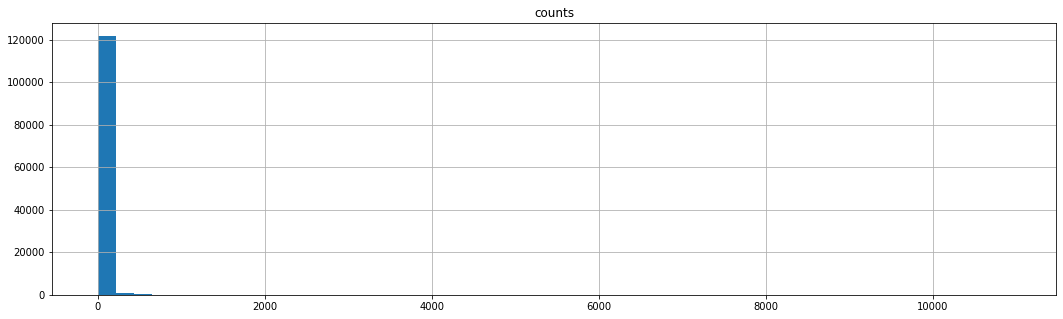

In [335]:
pair_counts.hist(column='counts', bins=50, figsize=(18,5))

Interestingly that most pairs do not have such a high frequency.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc85a292f90>]],
      dtype=object)

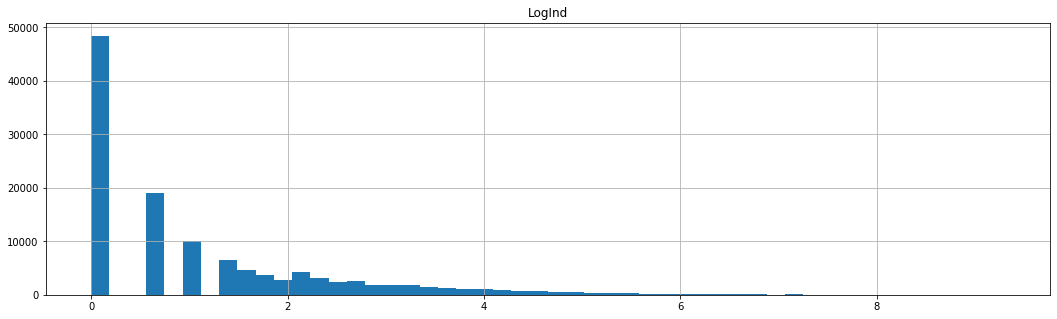

In [336]:
pair_counts['LogInd']=np.log(pair_counts['counts'])

pair_counts.hist(column='LogInd', bins=50, figsize=(18,5))

## African Cuisine

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

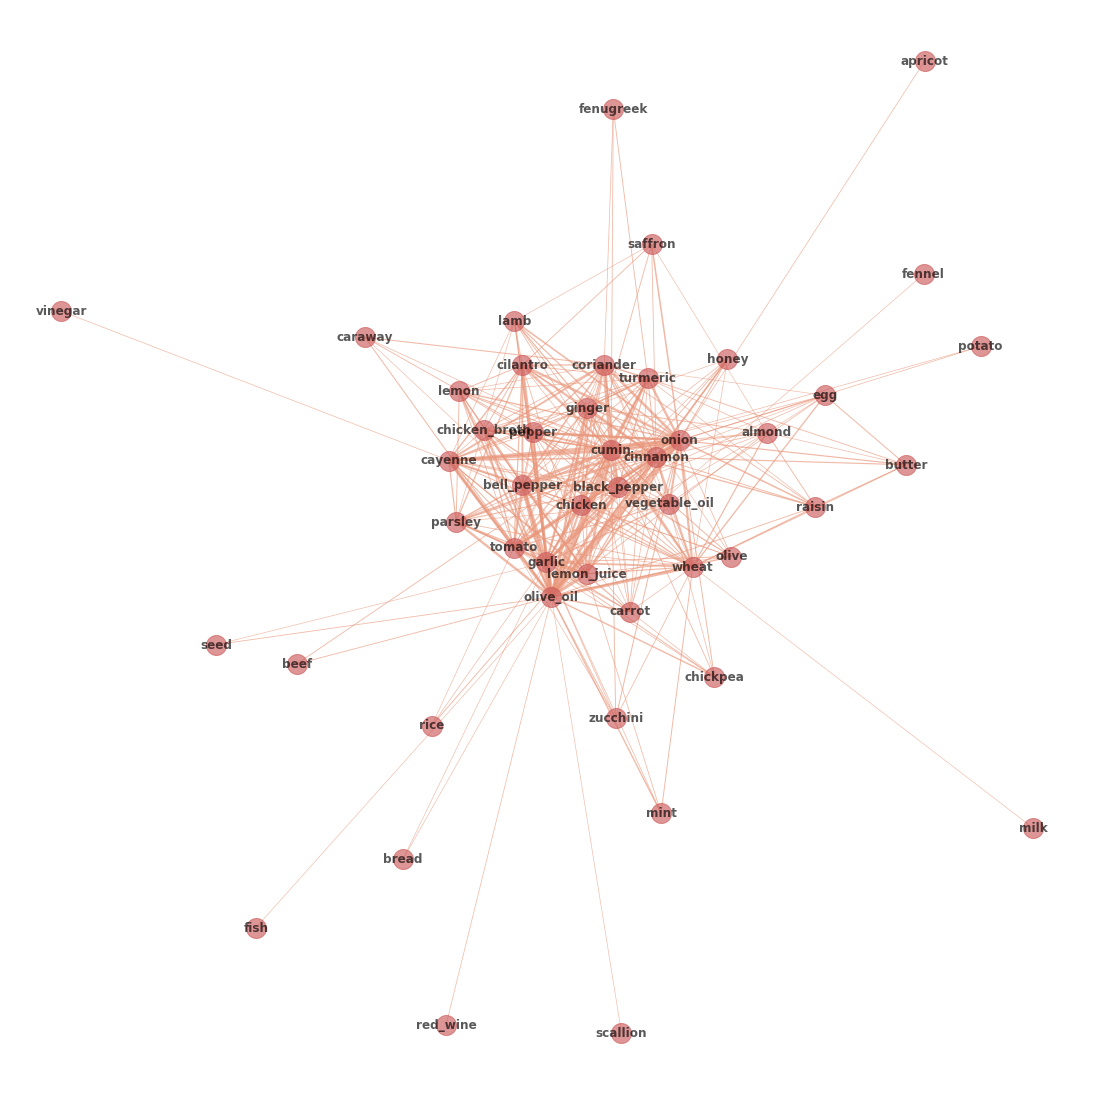

In [393]:
A=nx.from_pandas_edgelist(pair_countsA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="indianred", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="darksalmon", alpha=0.65)

## East Asian Cuisine

In [379]:
pair_countsEA=pair_counts[(pair_counts['counts']>70) & (pair_counts['Cuisine']=='EastAsian')]
pair_countsEA.shape

(322, 7)

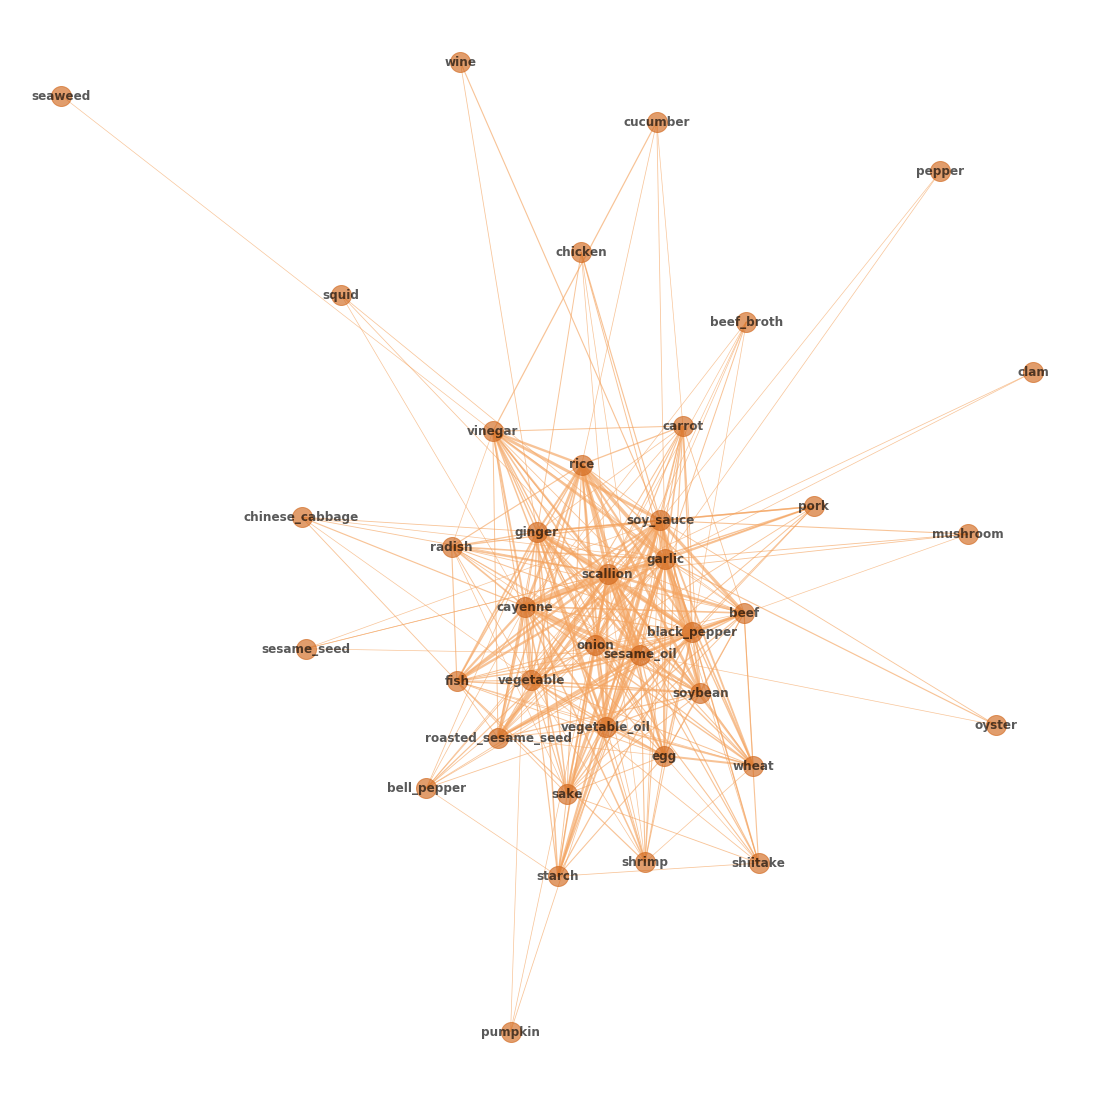

In [394]:
EA=nx.from_pandas_edgelist(pair_countsEA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in EA.edges(data=True)]
nx.draw(EA, with_labels=True, node_color="chocolate", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="sandybrown", alpha=0.65)

## Eastern European Cuisine

In [389]:
pair_countsEE=pair_counts[(pair_counts['counts']>7) & (pair_counts['Cuisine']=='EasternEuropean')]
pair_countsEE.shape

(348, 7)

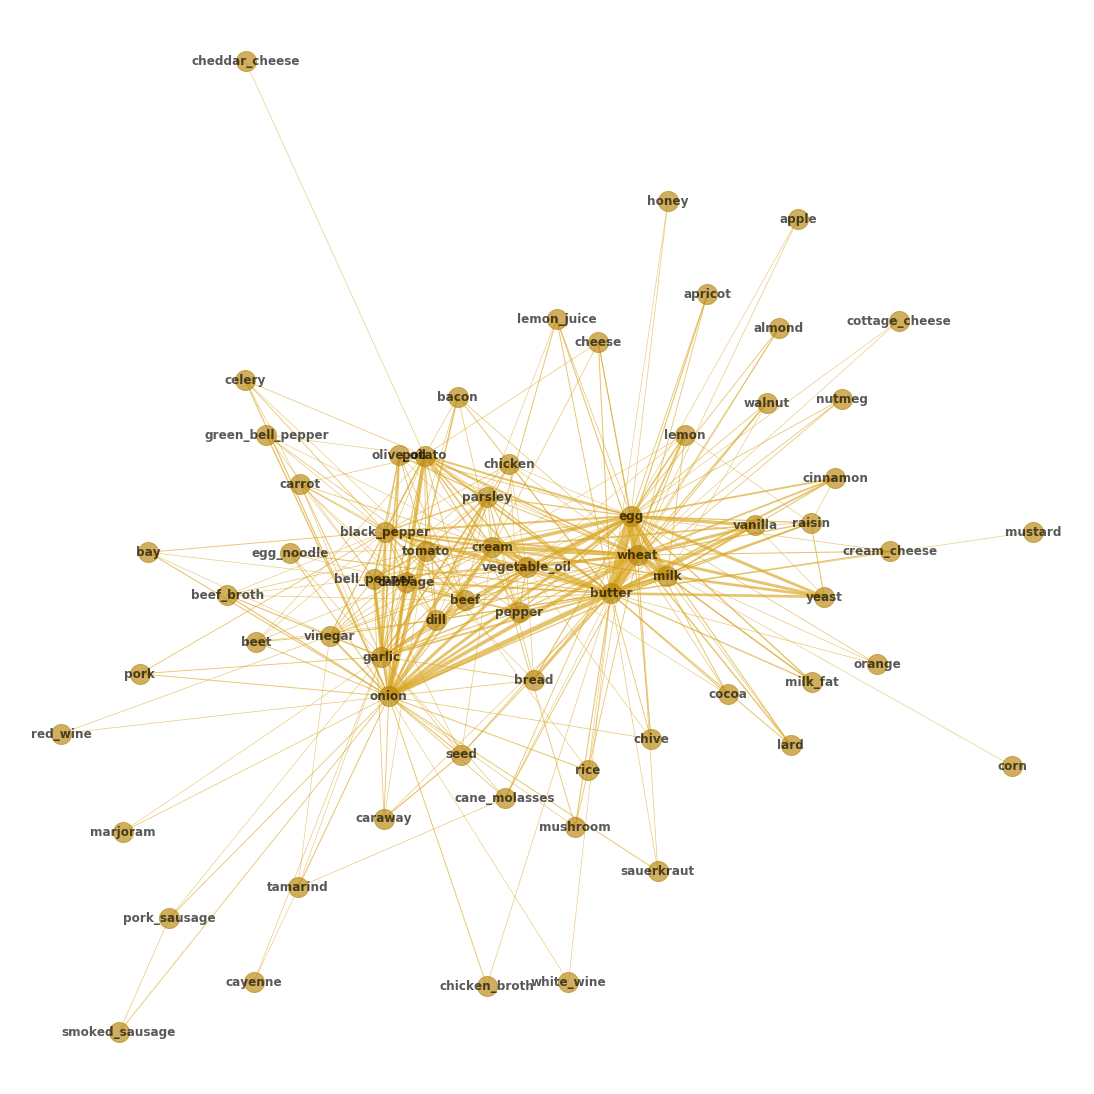

In [395]:
EE=nx.from_pandas_edgelist(pair_countsEE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in EE.edges(data=True)]
nx.draw(EE, with_labels=True, node_color="darkgoldenrod", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="goldenrod", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

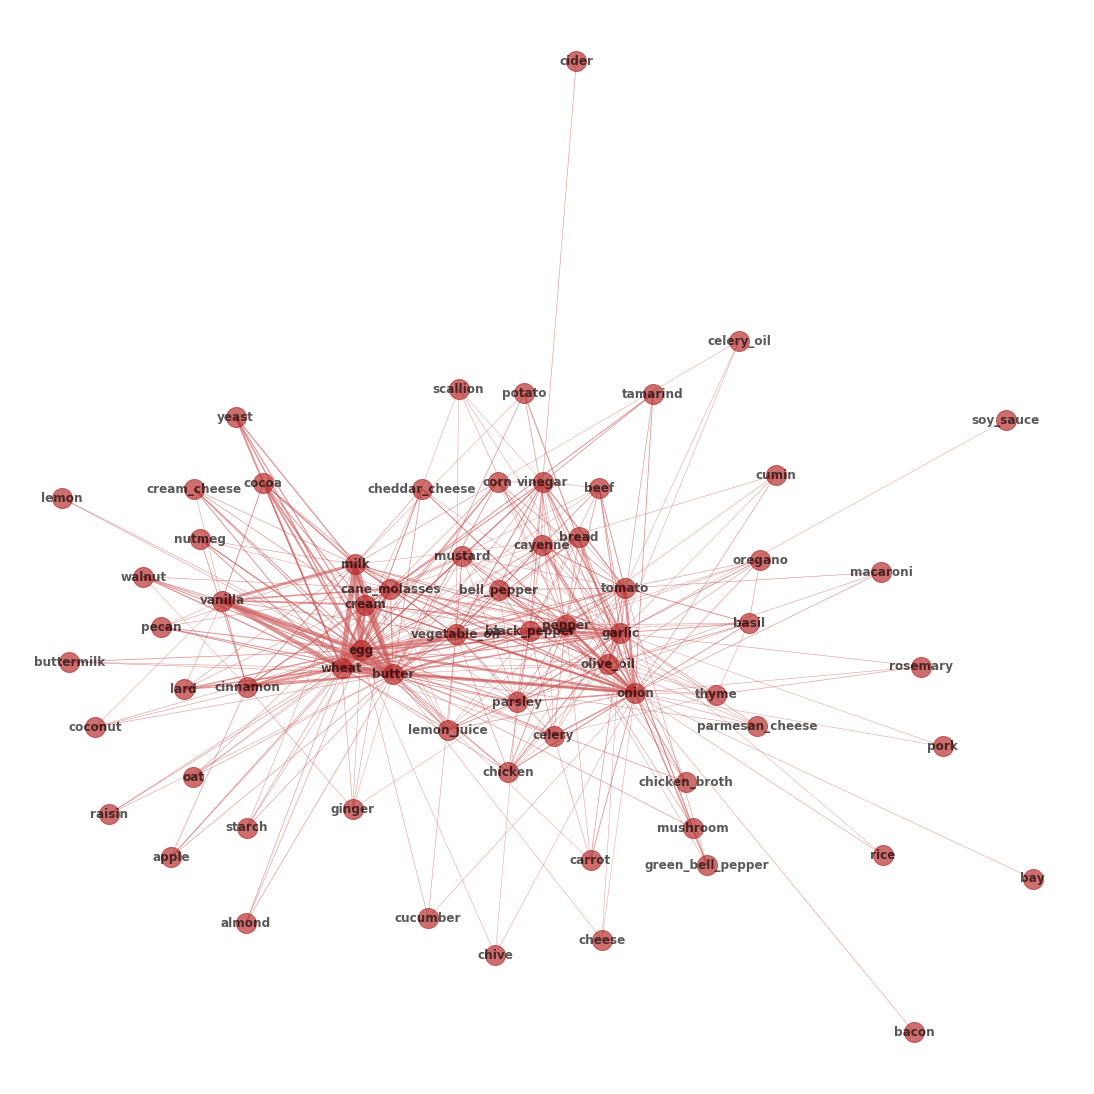

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

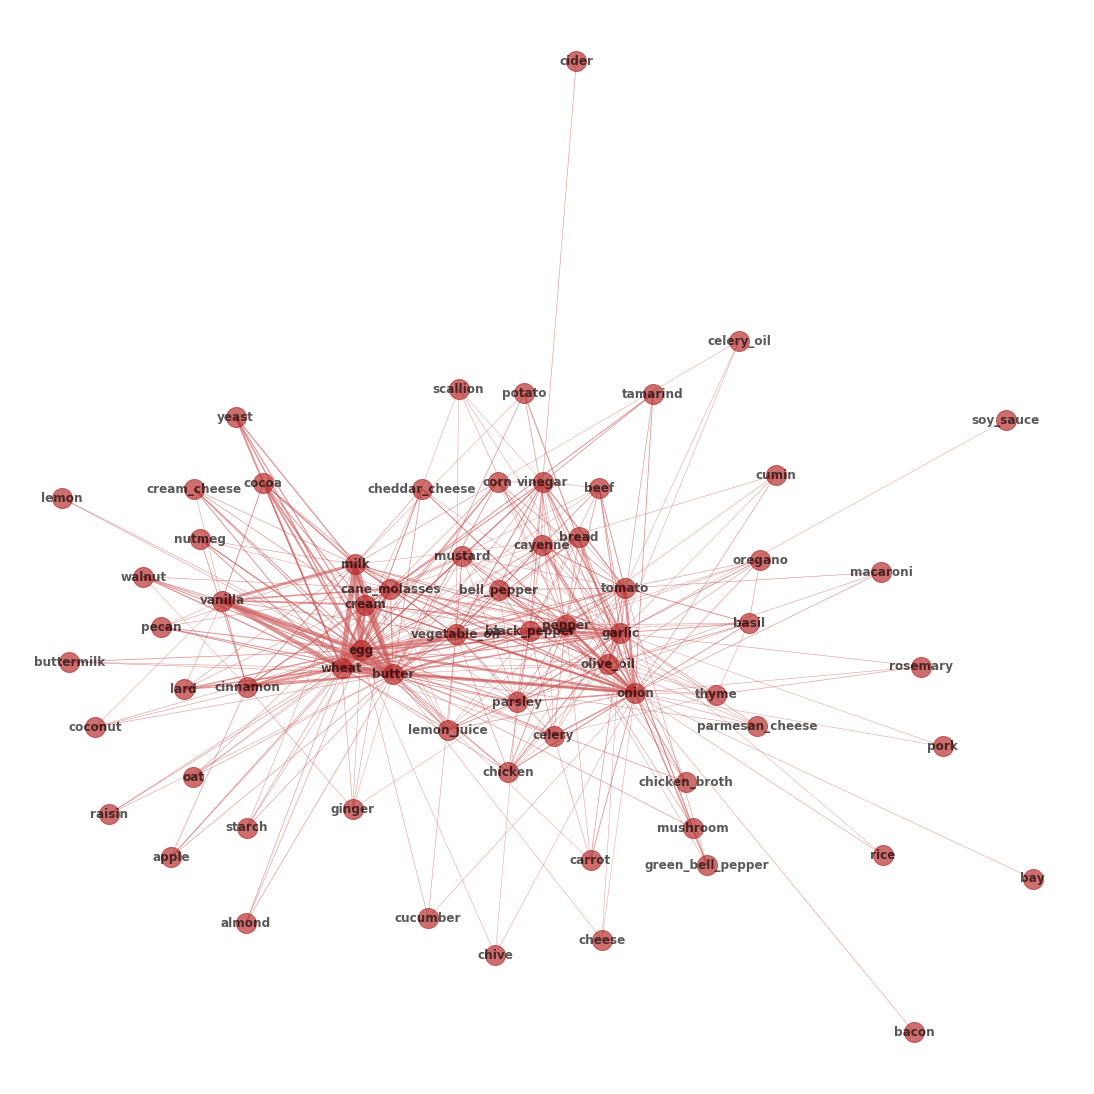

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

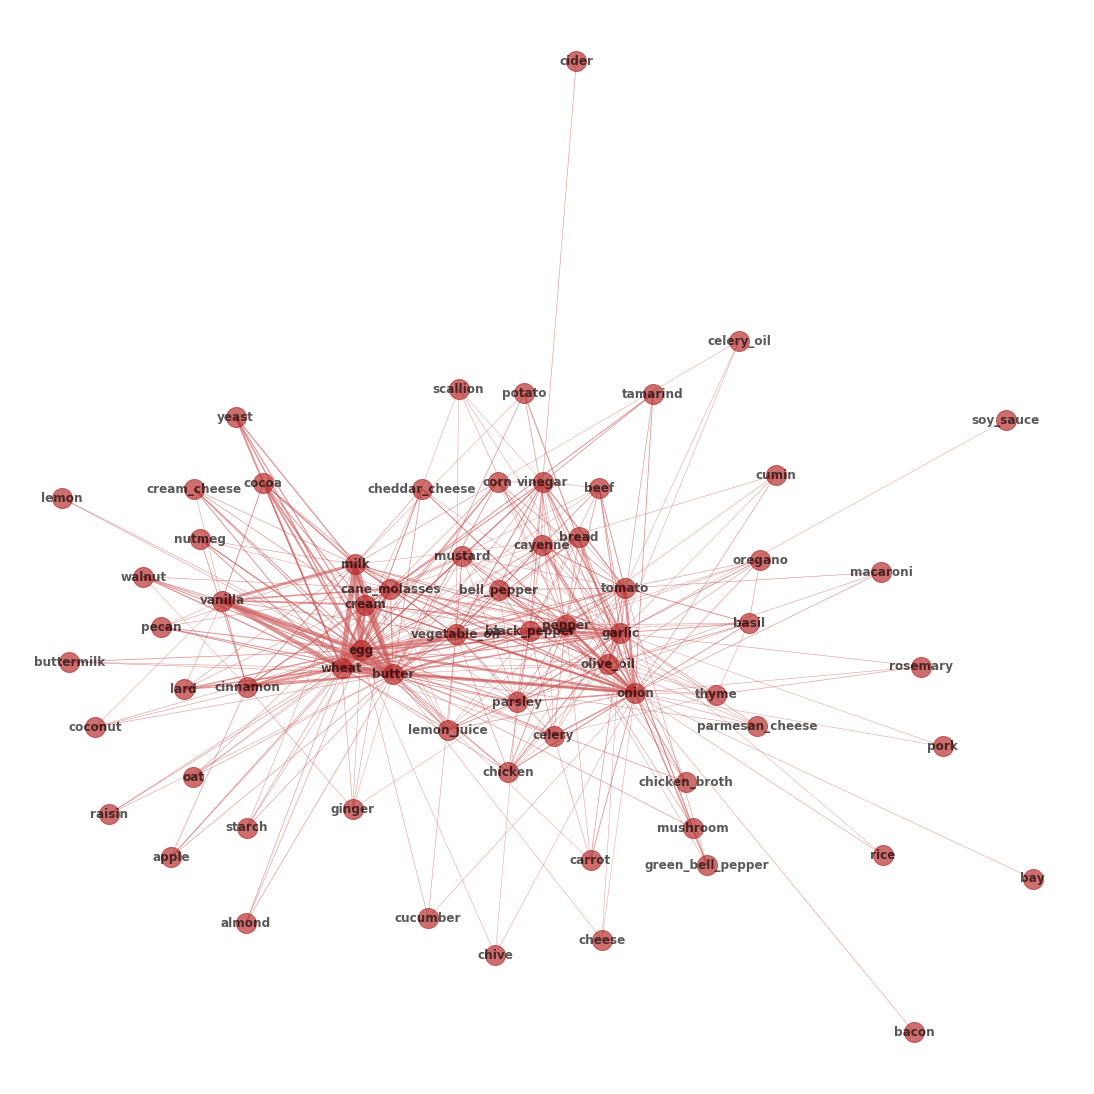

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

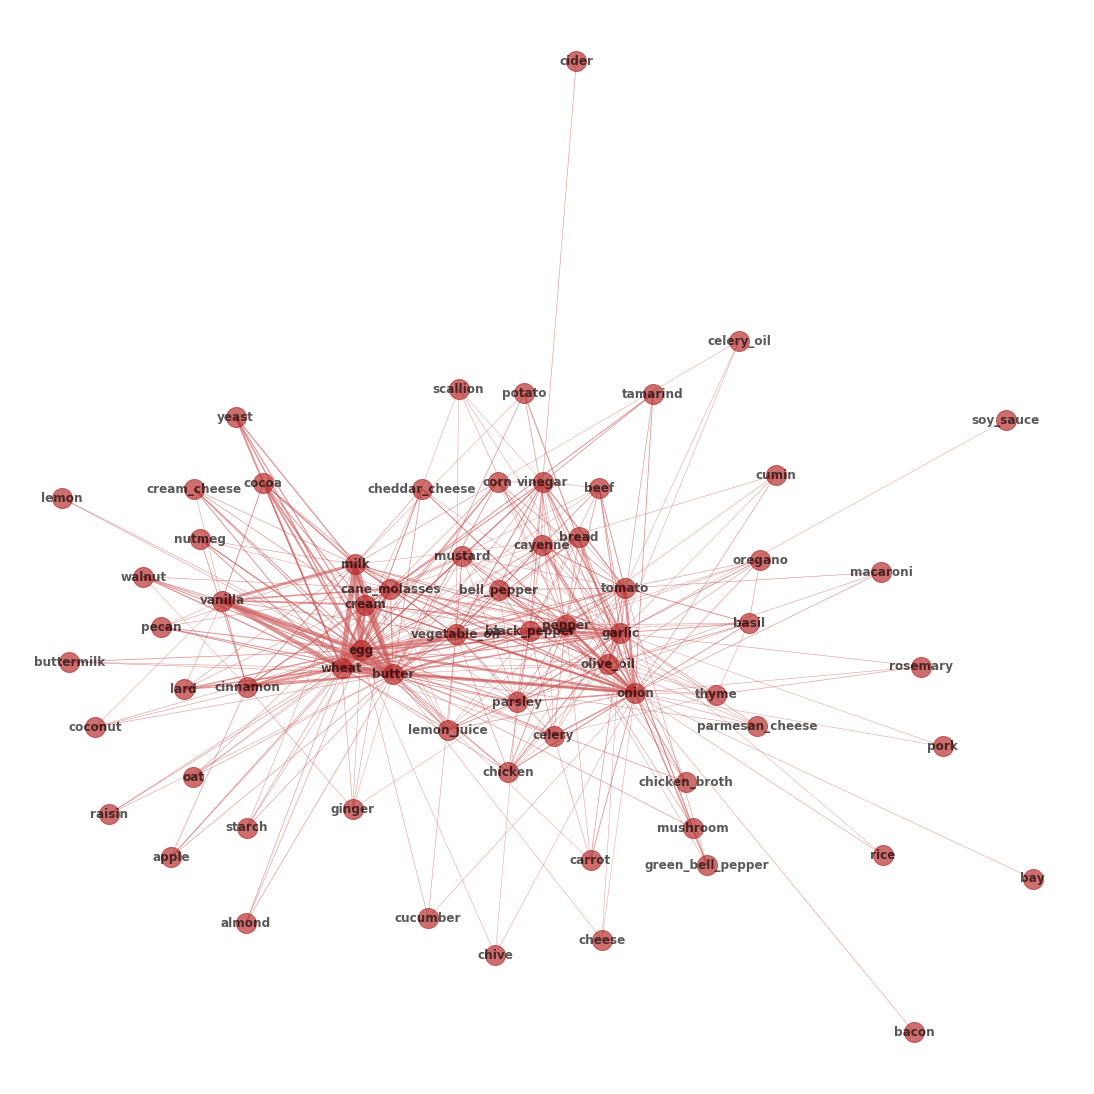

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

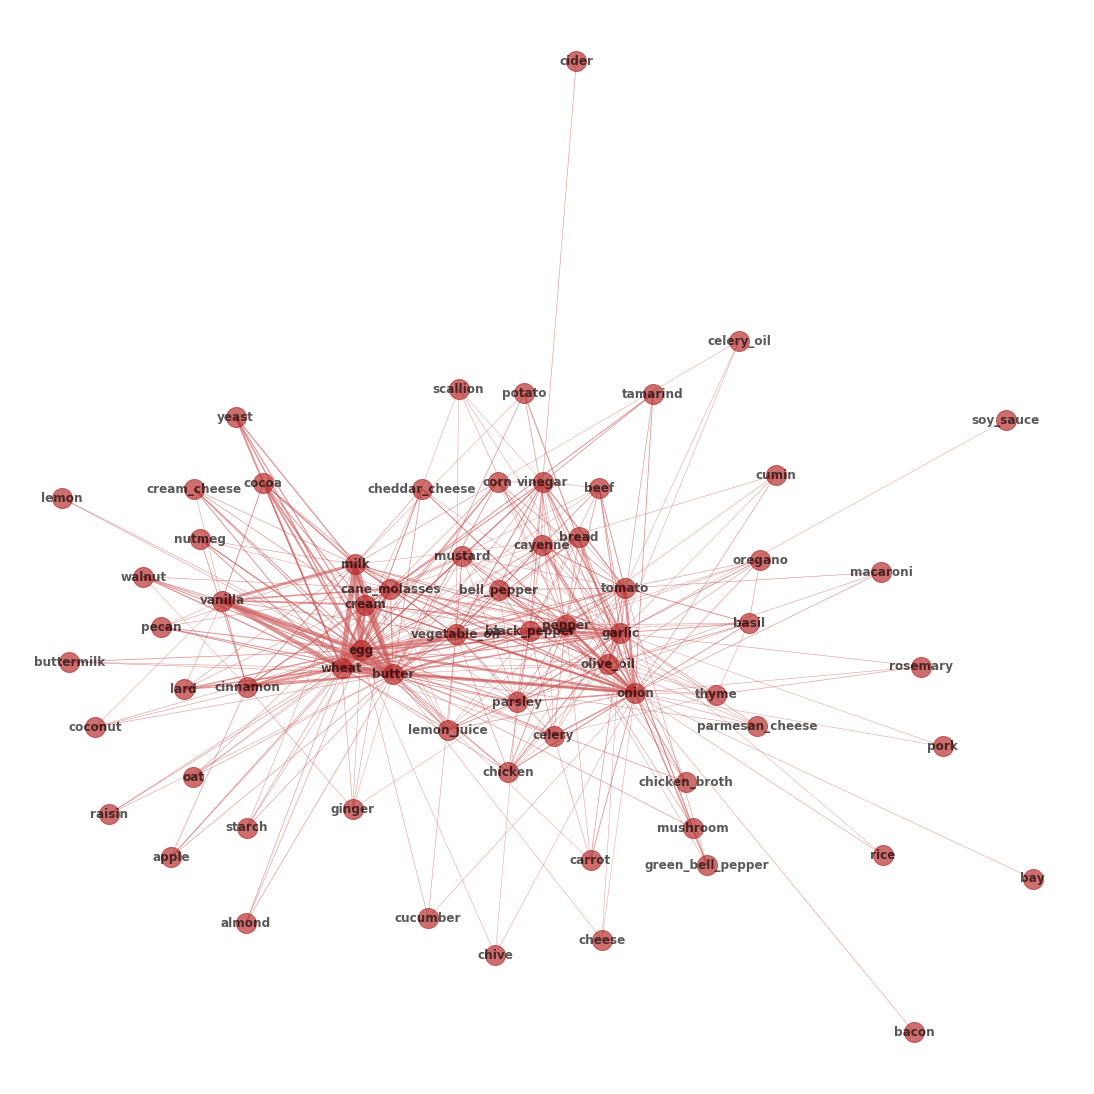

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

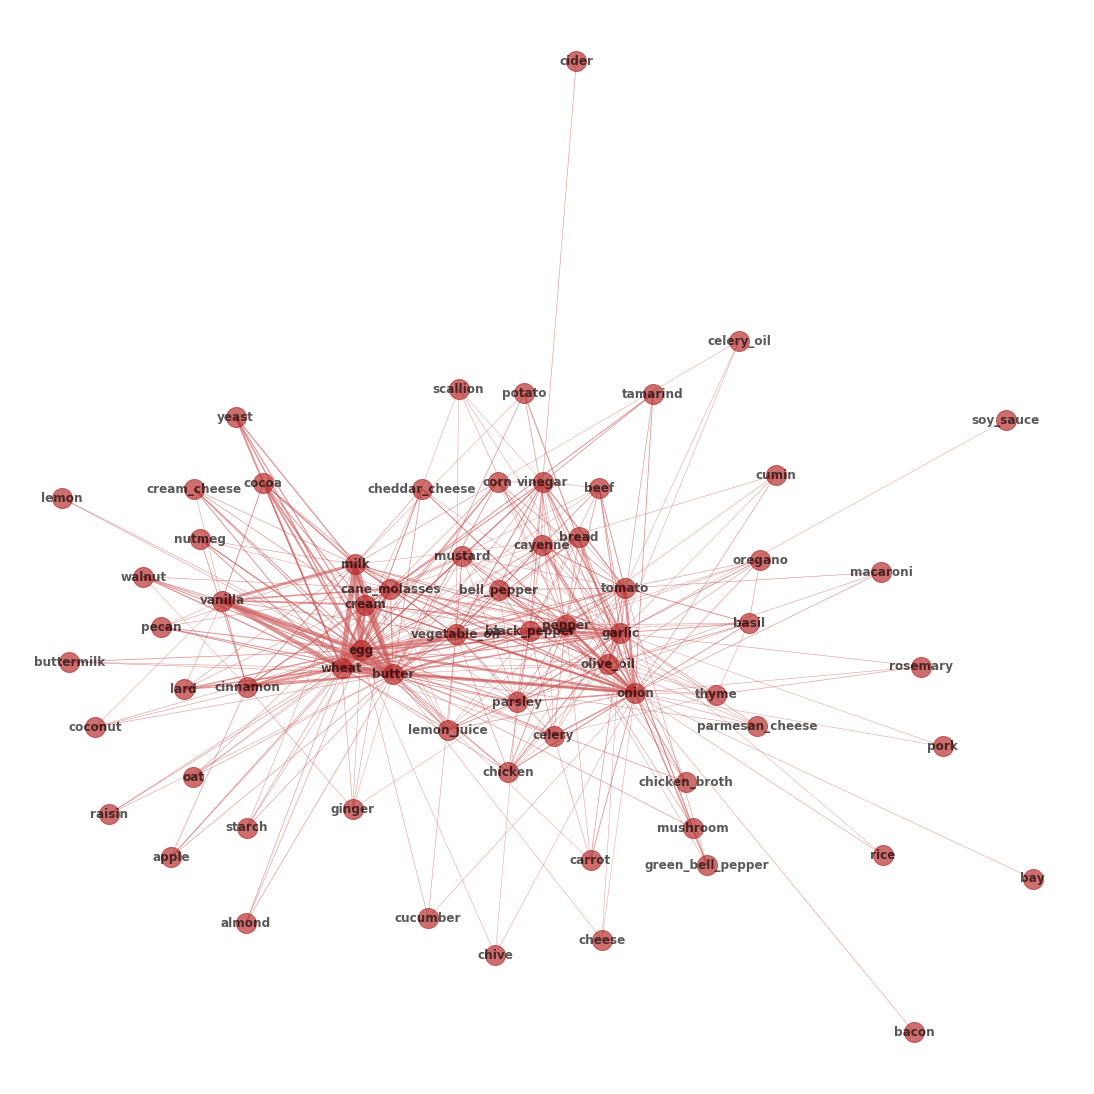

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

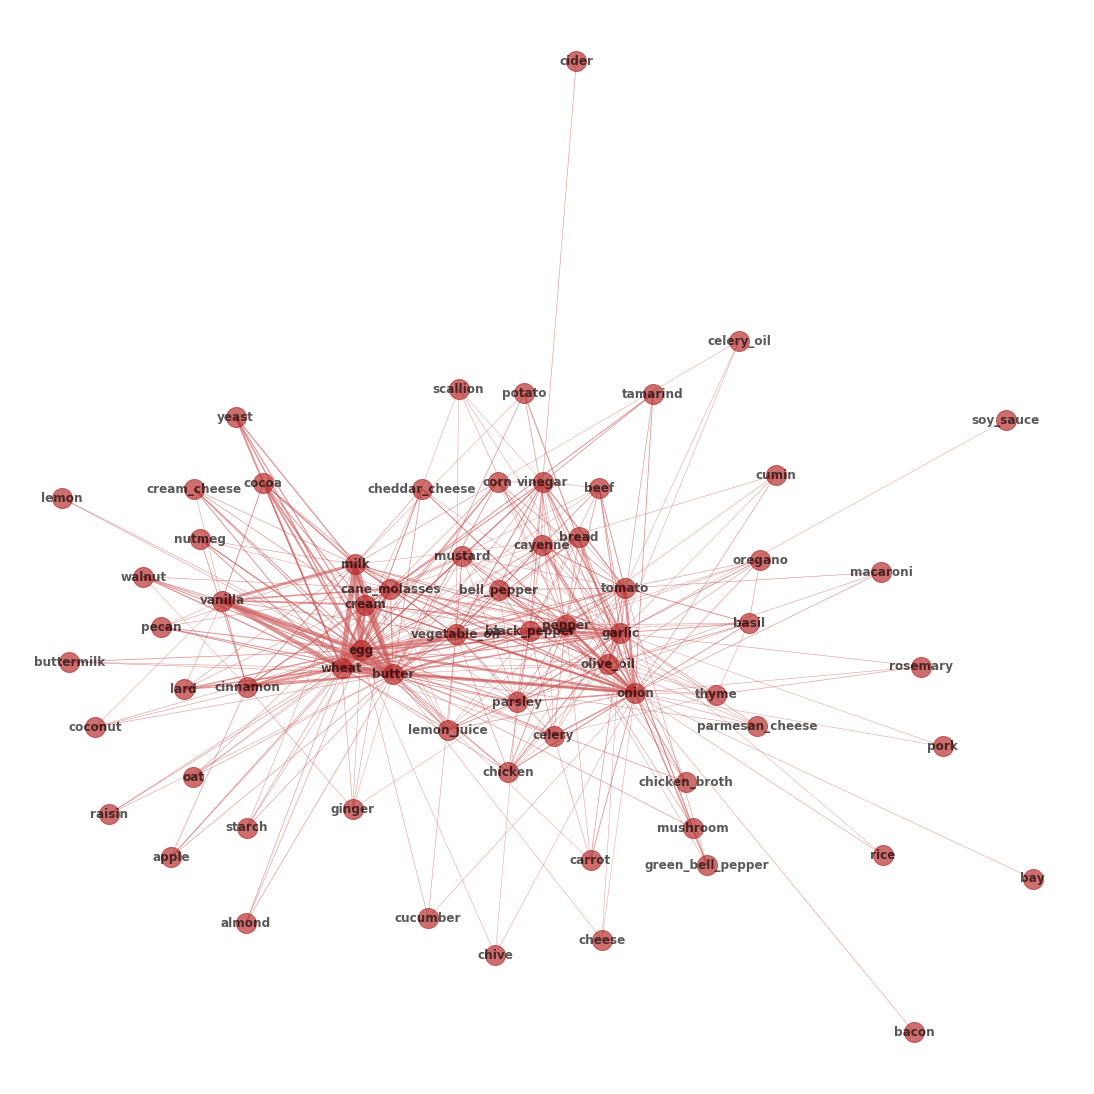

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

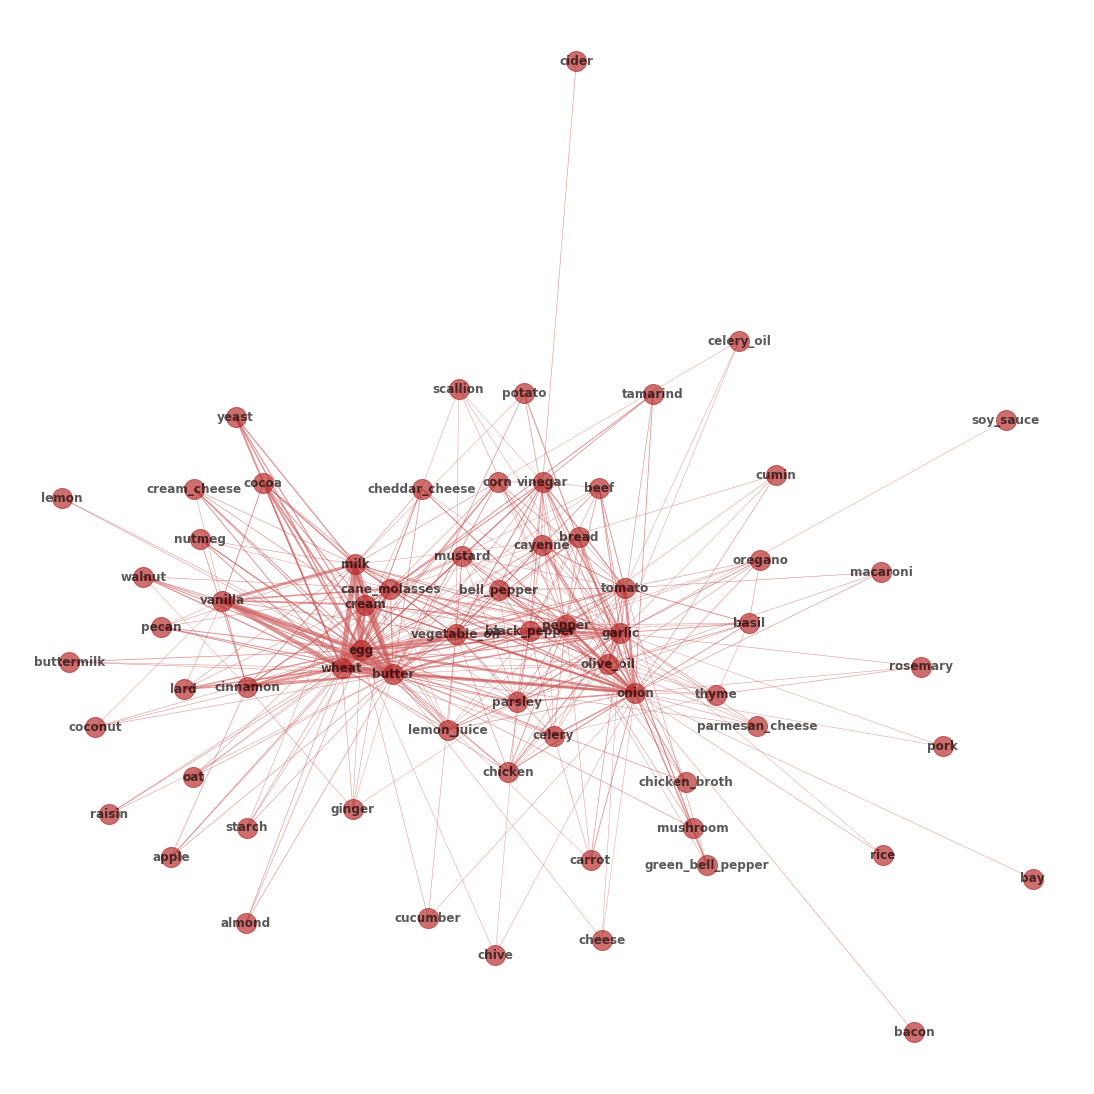

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

In [372]:
pair_countsA=pair_counts[(pair_counts['counts']>12) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(327, 7)

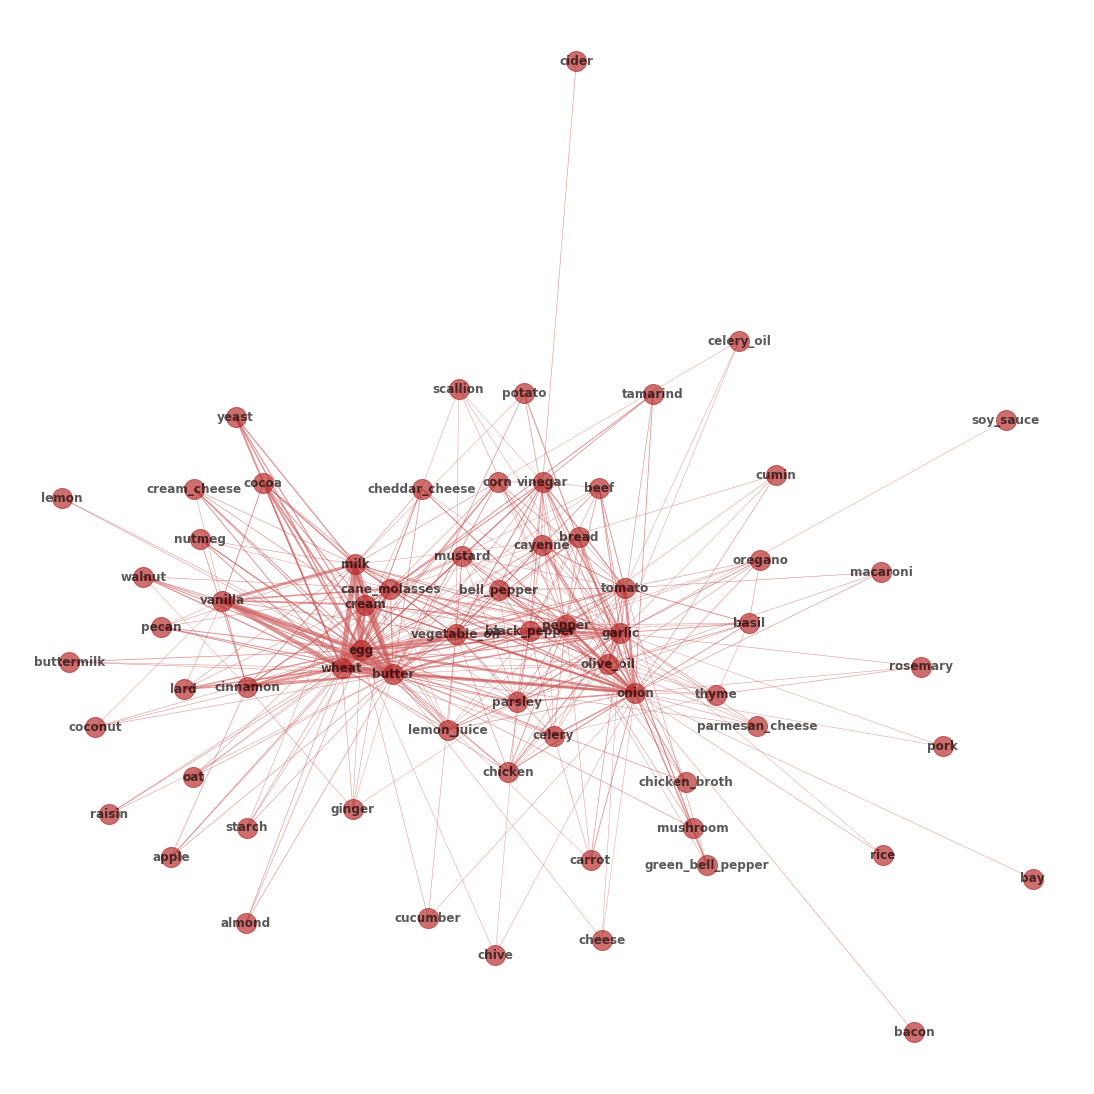

In [374]:
A=nx.from_pandas_edgelist(pair_counts2, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*10 for f,t,edata in A.edges(data=True)]
nx.draw(A, with_labels=True, node_color="firebrick", node_size=400, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.65)

### 4. Analysis


#### 4.1 Number of Ingredients by Cuisine.

In [ ]:
temp=32-COU.isnull().sum(axis=1)
tempdf=temp.to_frame()
temp1=tempdf.join(COU, how='outer')

In [ ]:
temp1.groupby('Cuisine').mean()

SoutheastAsian recipies have the most ingredients, while NorthernEuropean ones have the fewest.

In [ ]:
plt.rcParams["figure.figsize"] = (14,6) # set plot size
temp1.groupby('Cuisine').mean().reset_index().plot.bar(x='Cuisine')

In [ ]:
temp2=temp1.reset_index()


plt.rcParams["figure.figsize"] = (15,15) # set plot size
temp1[0].hist(by=temp1['Cuisine'],bins=25)

Histograms of number of ingredients by cuisine

#### 4.2 Venn Diagram


In [ ]:
import matplotlib_venn as venn

from matplotlib_venn import venn3

In [ ]:
VD=COU2[['Cuisine','Ing']]
VD1=VD.dropna()
afr=VD1[VD1['Cuisine']=='African']
ea=VD1[VD1['Cuisine']=='EastAsian']
ee=VD1[VD1['Cuisine']=='EasternEuropean']
la=VD1[VD1['Cuisine']=='LatinAmerican']
me=VD1[VD1['Cuisine']=='MiddleEastern']
na=VD1[VD1['Cuisine']=='NorthAmerican']
ne=VD1[VD1['Cuisine']=='NorthernEuropean']
sa=VD1[VD1['Cuisine']=='SouthAsian']
sea=VD1[VD1['Cuisine']=='SoutheastAsian']
se=VD1[VD1['Cuisine']=='SouthernEuropean']
we=VD1[VD1['Cuisine']=='WesternEuropean']

In [ ]:
set1 = set(afr['Ing'])
set2 = set(ea['Ing'])
set3 = set(ee['Ing'])
set4 = set(la['Ing'])
set5 = set(me['Ing'])
set6 = set(na['Ing'])
set7 = set(ne['Ing'])
set8 = set(sa['Ing'])
set9 = set(sea['Ing'])
set10 = set(se['Ing'])
set11 = set(we['Ing'])

In [ ]:
plt.rcParams["figure.figsize"] = (11,6) # set plot size
venn3([set1, set2, set3], ('African', 'EastAsian', 'EasternEuropean'))

Interesting, African cuisine has 18 unique ingredients, while East Asian has 50!, and Eastern European has only 15.

18 unique African ingredients:

In [ ]:
set1.difference(set2).difference(set3)

Analysis of 18 ingredients leads us to conclude that data is very incomplete. Peach is used in East Asian cuisine for instance and sunflower oil is extremly popular in Eastern Europe. So it is not clear why these ingredients were not include in the dataset.

50 unique East Asian ingredients:

In [ ]:
set2.difference(set1).difference(set3)

As coming from Eastern Europe, I can pinpoint that beef liver, grape, melon, oatmeal, and watermelon are all common ingredients in Eastern Europe, so the reasons for exclusion is not clear.

15 unique Eastern Europen ingredients:

In [ ]:
set3.difference(set1).difference(set2)

In [ ]:
venn3([set4, set5, set6], ('LatinAmerican', 'MiddleEastern', 'NorthAmerican'))

North American cuisine has 69 unique ingredients, that are not part of either Latin American or Middle Eastern cuisine. All 3 cuisines share 200 common ingredients.

In [ ]:
venn3([set7, set8, set9], ('NorthernEuropean', 'SouthAsian', 'SoutheastAsian'))

These 3 cuisines have a lot unique ingredients. Northern European has 28 ingredients it does not share with other 2. While Southeast Asian has 27 unique ingredients and South Asian 31.

In [ ]:
venn3([set10, set11, set2], ('SouthernEuropean', 'WesternEuropean', 'EastAsian'))

Surprisingly, these 3 cuisines have huge overlap with each other, even though East Asian does not use ~ 100 ingredients that European cousins do. 

#### 4.3 Unique Ingredients by Cuisine.

African cuisne does not have any ingredients that are not part of 10 other cuisines. 

East Asian has 6 unique ingredients. I am not clear what raw beef means. If it is not cooked then French eat raw beef as well. 

In [ ]:
set2.difference(set1).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7).difference(set8).difference(set9).difference(set10).difference(set11)

Eastern European, Latin American, Middle Eastern cuisines do not have unique ingredients.

North America has 20 unique ingredients. Again, I do not agree with data. Jasmine tea is much more popular in East Asia, than in North America. The same applies to mate, more popular in South America. Again, roasted hazelnut consumed in Europe and Middle East. And carob is consumed widely in Middle East. And as a last straw, sturgeon caviar made to North American list, but not to Eastern European! So on, and so on.

In [ ]:
set6.difference(set1).difference(set2).difference(set3).difference(set4).difference(set5).difference(set7).difference(set8).difference(set9).difference(set10).difference(set11)

Southeast Asian unique ingredients are:

In [ ]:
set9.difference(set1).difference(set2).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7).difference(set8).difference(set10).difference(set11)

Southern European unique ingredients are:

In [ ]:
set10.difference(set1).difference(set2).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7).difference(set8).difference(set9).difference(set11)

Western European unique ingredients are (I am not sure that Jamacain people will agree that Jamaican Rum is uniqely Western European):

In [ ]:
set11.difference(set1).difference(set2).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7).difference(set8).difference(set9).difference(set10)

#### 4.4 Most Common Ingredients by Cuisine.

In [ ]:
pd.set_option('display.max_rows', 400)
temp1=COU2.groupby(['Cuisine','Ing']).count()
temp1.sort_values(['Cuisine','variable'],ascending = False).groupby('Cuisine').head(10)

Depending on cuisine, the most common ingredients are different. For instance, for Western European, the most common ingredients are butter, egg, and wheat, while for African are olive oil, onion, and cumin.

Some observations:

- Butter is the most common ingredient in Western Europe, Northern Europe, North America, and Eastern Europe. However, it does not make in top 3 in any other cuisines. In Southern Europe, it is # 10, in Middle East # 6.
- Olive oil is # 1 ingredient in Southern Europe and Africa, in Middle East it is the 2nd most common ingredient. In Western Europe it is # 9.
- Garlic - number 1 in Southeast Asian, number 2 in Southern Europe and East Asia, number 3 in Latin America. # 8 in Western Europe, # 5 in South Asia, # 6 in North America, # 5 in Middle East, # 8 in Eastern Europe, # 4 in Africa. I think we can say that garlic is loved all around the world, except for Northern Europe.
- Cumin - number 1 in South Asia, number 3 in Africa
- Wheat - number 1 in Middle East, number 2 in Northern Europe, number 3 in Western Europe, Eastern Europe, and North America
- Cayenne - number 1 in Latin America, number 3 in Southeast Asia
- Soy Sauce - number 1 in East Asia
- Fats - as we already mentioned, the most common fat in Western Europe, Northern Europe, North America, and Eastern Europe is butter. In Southern Europe, Africa, and Middle East, it is olive oil. In Southeast Asia, South Asia, and Latin America, it is generic vegetable oil. In East Asia, it is sesame oil.
- Most common protein - in Western Europe, Southern Europe, Northern Europe, North America, Middle East, Eastern Europe it is egg. In Southeast Asia, it is fish. In South Asia, it is yogurt. In Latin America, it is cheese. In East Asia, soybean. In Africa, it is chicken.
- Most common carbs - in Western Europe, Southern Europe, Northern Europe, North America, Middle East, Eastern Europe, and Africa it is wheat. In Southeast Asia, South Asia, and East Asia it is rice. In Latin America, it is corn.  
- Most common spice - in Western Europe, Northern Europe, North America, Middle East, Eastern Europe, and Africa - onion. In Southern Europe, Southeast Asia, and East Asia, garlic. In South Asia, cumin. In Latin America, cayenne.
- Most common vegetable - in Western Europe, Northern Europe, and Eastern Europe, potato. In Southern Europe, South Asia, North America, Middle East, and Latin America, tomato. In Southeast Asia and Africa, bell pepper. In East Asia, carrot.
- The most common meat - 


#### 4.5 Most Common Ingredient Pairs by Cuisine

In [ ]:
pairs3.sort_values(['Cuisine','index'],ascending = False).groupby('Cuisine').head(6)

Observations:

- Butter and Wheat - in Western European and Northern European cuisines, mit is the most common combination. In North America and Eastern Europe, it is the second most common. Butter is also commonly cooked with egg. Wheat is also commonly cooked with egg as well.
- Olive Oil and Garlic - in Southern Europe, it is the most common combination. In Middle East and Africa, it is the second most common combination. Both olive oil and garlic often cooked with tomatoes. Olive oil is also common,y cooked with cummin and onions.
- Garlic and Vegetable Oil - similar to Olive Oil and Garlic above, in Southeast Asia, it is the most common combination.
- Cumin and Tumeric - these 2 spices is the most common combination in South Asia. Both of these spices are often cooked with coriander.
- Wheat and Egg - as already mentioned, this is a popular combination. Actually, it is # 1 combination in Northern America, Middle East, and Eastern Europe.
- Onion and Cayenne - spicy! The most common combination in Latin America. Onion is also commonly cooked with olive oil and tomato.
- Cayenne and Scalion - spicy again. The most common combination is East Asia.
- Olive Oil and Cumin - the most common combination in Africa.
- Fat + Carb Combo - we have seen very common combo, such as Butter and Wheat, to some extend Egg and Wheat, Milk and Wheat, Wheat and Cream can be included
- Fat + Spice - a lot of combinations, such as Olive Oil and Garlic, Olive Oil and Onion, Olive Oil and Basil, Olive Oil and Cumin, Vegetable Oil and Garlic, Olive Oil and Parsley, Sesame Oil and Soy Sauce, Sesame Oil and Scallion, Sesame Oil and Garlic
- Spice + Spice - extremly popular. Examples are Ginger and Garlic, Coriander and Cumin, Cumin and Tumeric (curry), Coriander and Tumeric, Onion and Cumin, Onion and Tumeric, Cayenne and Cumin, Onion and Cayenne, Onion and Garlic, Cayenne and Garlic, and many more

As we already started to see, different cuisines use different ingredients and different approaches to food combinations.